In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

from lsst.sims.maf.metrics import BaseMoMetric

In [3]:
try:
    k = []
    for ki in list(metrics.BaseMetric.registry.keys()):
        if "Color" in ki:
            k.append(ki)
    for ki in k:
        del metrics.BaseMetric.registry[ki]
except KeyError:
    pass


def _setVis(ssoObs, snrLimit, snrCol, visCol):
    if snrLimit is not None:
        vis = np.where(ssoObs[snrCol] >= snrLimit)[0]
    else:
        vis = np.where(ssoObs[visCol] > 0)[0]
    return vis


class Color_AsteroidMetric(BaseMoMetric):
    """
    This metric is appropriate for MBAs and NEOs, and other inner solar system objects.
    
    The metric evaluates if the SNR-weighted number of observations are enough to 
    determine an approximate lightcurve and phase function -- and from this, 
    then a color for the asteroid can be determined.
    The assumption is that you must fit the lightcurve/phase function in each bandpass, 
    and could do this well-enough if you have at least weightDet SNR-weighted observations 
    in the bandpass. 
    e.g. to find a g-r color, you must have 10 (SNR-weighted) obs in g and 10 in r.
    
    For more details, see 
    https://docs.google.com/document/d/1GAriM7trpTS08uanjUF7PyKALB2JBTjVT7Y6R30i0-8/edit?usp=sharing
    
    Parameters
    ----------
    weightDet: float, opt
        The SNR-weighted number of detections required (per bandpass in any ONE of the filters in filterlist).
        Default 10.
    snrLimit: float or None, opt
        If snrLimit is set as a float, then requires object to be above snrLimit SNR in the image.
        If snrLimit is None, this uses the probabilistic 'visibility' calculated by the vis stacker,
        which means SNR ~ 5.   Default is None.
    snrMax: float, opt
        Maximum value toward the SNR-weighting to consider. Default 20.
    filterlist: list of str, opt
        The filters to search for lightcurves and colors. 
        
    Returns
    -------
    int
        An integer 'flag' that indicates whether the mean magnitude (and thus a color) was determined in:
        0 = no bands
        1 = g and (r or i) and (z or y). i.e. obtain colors g-r or g-i PLUS g-z or g-y
        2 = Any 4 different filters (from grizy). i.e. colors = g-r, r-i, i-z, OR r-i, i-z, z-y..
        3 = All 5 from grizy. i.e. colors g-r, r-i, i-z, z-y.
        4 = All 6 filters (ugrizy) -- best possible! add u-g.
    """
    def __init__(self, weightDet=10, snrMax=20, snrLimit=None, 
                 filterlist=('u', 'g', 'r', 'i', 'z', 'y'), **kwargs):
        """
        @ snrLimit .. if snrLimit is None, this uses the _calcVis method/completeness to determine visibilty
                      if snrLimit is not None, this uses that value as a cutoff instead.
        @ weightDet .. is the minimum weighted SNR sum that is required to be able to extract a
                       lightcurve period. Default 10.
        """
        super().__init__(**kwargs)
        self.weightDet = weightDet
        self.snrLimit = snrLimit
        self.snrMax = snrMax
        self.filterlist = filterlist

    def run(self, ssoObs, orb, Hval):
        clipSnr = np.minimum(ssoObs[self.snrCol], self.snrMax)
        if self.snrLimit is not None:
            clipSnr = np.where(ssoObs[self.snrCol] <= self.snrLimit, 0, clipSnr)
        else:
            clipSnr = np.where(ssoObs[self.visCol] == 0, 0, clipSnr)
        if len(np.where(clipSnr > 0)[0]) == 0:
            return self.badval
            
        # Evaluate SNR-weighted number of observations in each filter.
        filterWeight = {}
        for f in self.filterlist:
            match = np.where(ssoObs[self.filterCol] == f)
            snrweight = np.sum(clipSnr[match]) / self.snrMax
            # If the snrweight exceeds the weightDet, add it to the dictionary.
            if snrweight > self.weightDet:
                filterWeight[f] = snrweight
                
        # Now assign a flag:
        # 0 = no bands
        # 1 = g and (r or i) and (z or y). i.e. obtain colors g-r or g-i PLUS g-z or g-y
        # 2 = Any 4 different filters (from grizy). i.e. colors = g-r, r-i, i-z, OR r-i, i-z, z-y..
        # 3 = All 5 from grizy. i.e. colors g-r, r-i, i-z, z-y.
        # 4 = All 6 filters (ugrizy) -- best possible! add u-g.
        all_six = set(['u', 'g', 'r', 'i', 'z', 'y'])
        good_five = set(['g', 'r', 'i', 'z', 'y'])
        
        if len(filterWeight) == 0:  # this lets us stop evaluating here if possible.
            flag = 0
        elif all_six.intersection(filterWeight) == all_six:
            flag = 4
        elif good_five.intersection(filterWeight) == good_five:
            flag = 3
        elif len(good_five.intersection(filterWeight)) == 4:
            flag = 2
        elif 'g' in filterWeight:
            # Have 'g' - do we have (r or i) and (z or y)
            if ('r' in filterWeight or 'i' in filterWeight) and ('z' in filterWeight or 'y' in filterWeight):
                flag = 1
            else:
                flag = 0
        else:
            flag = 0

        return flag
    
class LightcurveColor_OuterMetric(BaseMoMetric):
    """
    This metric is appropriate for outer solar system objects, such as TNOs and SDOs.

    This metric evaluates whether the number of observations is sufficient to fit a lightcurve
    in a primary and secondary bandpass. The primary bandpass requires more observations than
    the secondary. Essentially, it's a complete lightcurve in one or both bandpasses, with at
    least a semi-complete lightcurve in the secondary band.

    The lightcurve/color can be calculated with any two of the bandpasses in filterlist.
    Contributed by Wes Fraser.

    Parameters
    ----------
    snrLimit: float or None, opt
        If snrLimit is set as a float, then requires object to be above snrLimit SNR in the image.
        If snrLimit is None, this uses the probabilistic 'visibility' calculated by the vis stacker,
        which means SNR ~ 5.   Default is None.
    numReq: int, opt
        Number of observations required for a lightcurve fitting. Default 30.
    numSecFilt: int, opt
        Number of observations required in a secondary band for color only. Default 20.
    filterlist: list of str, opt
        Filters that the primary/secondary measurements can be in.

    Returns
    -------
    float
        A flag that indicates whether a color/lightcurve was generated in:
        0 = no lightcurve or color
        1 = a lightcurve in a single filter
        2+ = lightcurves in more than one filter
        x.5 = x lightcurves, but also additional colors (1 or more filters reached numSecFilt level)
    """
    def __init__(self, snrLimit=None, numReq=30, numSecFilt=20,
                 filterlist=('u', 'g', 'r', 'i', 'z', 'y'), **kwargs):
        super().__init__(**kwargs)
        self.snrLimit = snrLimit
        self.numReq = numReq
        self.numSecFilt = numSecFilt
        self.filterlist = filterlist

    def run(self, ssoObs, orb, Hval):
        vis = _setVis(ssoObs, self.snrLimit, self.snrCol, self.visCol)
        if len(vis) == 0:
            return 0

        lightcurves = set()
        colors = set()
        for f in self.filterlist:
            nmatch = np.where(ssoObs[vis][self.filterCol] == f)[0]
            if len(nmatch) >= self.numReq:
                lightcurves.add(f)
            if len(nmatch) >= self.numSecFilt:
                colors.add(f)
        
        # Set the flags - first the number of filters with lightcurves.
        flag = len(lightcurves)
        # And check if there were extra filters which had enough for a color 
        # but not enough for a lightcurve.
        if len(colors.difference(lightcurves)) > 0:
            flag += 0.5
        return flag

In [4]:
# Read in some test observations and test orbits
orbitfile = 'mbas_test.des'
obsfile = 'baseline2018a__mbas_test_obs.txt'
Hrange = np.arange(15, 20.5, 1)
s = slicers.MoObjSlicer(Hrange=Hrange)
s.setupSlicer(orbitFile=orbitfile, obsFile=obsfile)

In [5]:
# We can test the metric on a single observation/H value by using it directly.
# But we do still need to run the MoMag stacker to add the apparent magnitude etc to the provided observations.
# We also need to run the ecliptic lat/lon stacker.
magstacker = stackers.MoMagStacker()
eclstacker = stackers.EclStacker()
Hval = 19
i = 0
testobs = magstacker.run(s[i]['obs'], Hval=Hval, Href=s[i]['orbit']['H'])
testobs = eclstacker.run(testobs, Hval=None, Href=None)
# See .. now we have SNR and vis and mag.
testobs['SNR'][0:10], testobs['SNR'].max(), testobs['SNR'].min()

(array([0.59578139, 0.42581548, 0.45046759, 0.46244202, 0.47295768,
        0.56889663, 0.17827207, 0.22939773, 2.58569428, 2.38506711]),
 17.747539882077167,
 0.04438528892240999)

In [6]:
# So now we can test the new metric on a single observation/H value..
m = Color_AsteroidMetric(snrLimit=None)
m.run(testobs, s[i]['orbit'], Hval)

0

In [7]:
# and test the other color metric.
m = LightcurveColor_OuterMetric(snrLimit=None)
m.run(testobs, s[i]['orbit'], Hval)

2.5

In [8]:
# And we can test it on more H values / orbits using the metric bundle & group
bundle1 = mb.MoMetricBundle(Color_AsteroidMetric(), s, stackerList=[magstacker, eclstacker])
bundle2 = mb.MoMetricBundle(LightcurveColor_OuterMetric(), s, stackerList=[magstacker, eclstacker])

In [9]:
g = mb.MoMetricBundleGroup({'colorA': bundle1, 'colorO': bundle2})
g.runAll()

Running metrics ['colorA', 'colorO']
Calculated and saved all metrics.


In [10]:
bundle1.metricValues

masked_array(
  data=[[4.0, 4.0, 3.0, 2.0, --, --],
        [4.0, 4.0, 3.0, 2.0, --, --],
        [4.0, 4.0, 4.0, 3.0, 3.0, --]],
  mask=[[False, False, False, False,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True]],
  fill_value=0.0)

In [11]:
bundle2.metricValues

masked_array(
  data=[[6.0, 5.5, 5.0, 3.5, 2.5, --],
        [6.0, 5.5, 5.0, 4.0, 1.0, --],
        [4.5, 4.5, 4.5, 4.5, 3.5, 2.0]],
  mask=[[False, False, False, False, False,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]],
  fill_value=0.0)

In [33]:
# We can summarize these into the "fraction of the population with value > X"
frac1 = metrics.MoCompletenessMetric(threshold=4, metricName='FractionPop_fullcolor')
frac2 = metrics.MoCompletenessMetric(threshold=3, metricName='FractionPop_fourcolor')
frac3 = metrics.MoCompletenessMetric(threshold=2, metricName='FractionPop_threecolor')
frac4 = metrics.MoCompletenessMetric(threshold=1, metricName='FractionPop_twocolor')
bundle1.setSummaryMetrics([frac1, frac2, frac3, frac4])
bundle1.computeSummaryStats()

Text(0, 0.5, 'Fraction of population')

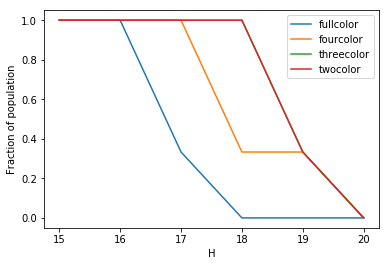

In [35]:
for name in ['fullcolor', 'fourcolor', 'threecolor', 'twocolor']:
    sname = f'FractionPop_{name}'
    plt.plot(Hrange, bundle1.summaryValues[sname]['value'], label=name)
plt.legend()
plt.xlabel("H")
plt.ylabel("Fraction of population")

In [37]:
# We can summarize these into the "fraction of the population with value > X"
frac1 = metrics.MoCompletenessMetric(threshold=1, metricName='FractionPop_oneband')
frac2 = metrics.MoCompletenessMetric(threshold=2, metricName='FractionPop_twoband')
frac3 = metrics.MoCompletenessMetric(threshold=3, metricName='FractionPop_more')
bundle2.setSummaryMetrics([frac1, frac2, frac3])
bundle2.computeSummaryStats()

Text(0, 0.5, 'Fraction of population')

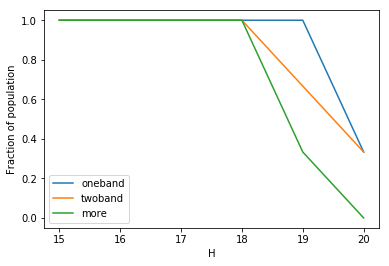

In [39]:
for name in ['oneband', 'twoband', 'more']:
    sname = f'FractionPop_{name}'
    plt.plot(Hrange, bundle2.summaryValues[sname]['value'], label=name)
plt.legend()
plt.xlabel("H")
plt.ylabel("Fraction of population")